# Try to add a nifty model for sampling the input map

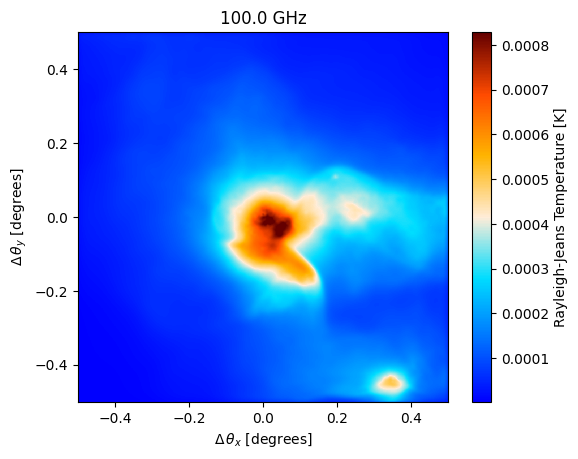

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/big_cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename,
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

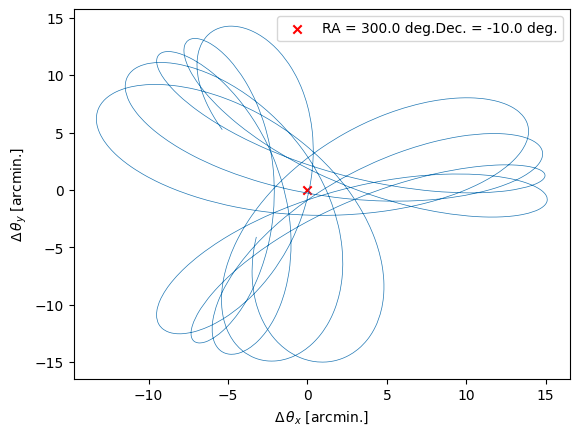

In [2]:
plan = maria.get_plan(scan_pattern="daisy",
                      # scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                    scan_options={"radius": 0.25, "speed": 0.18}, # in degrees
                      duration=60, # in seconds
                      sample_rate=225, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

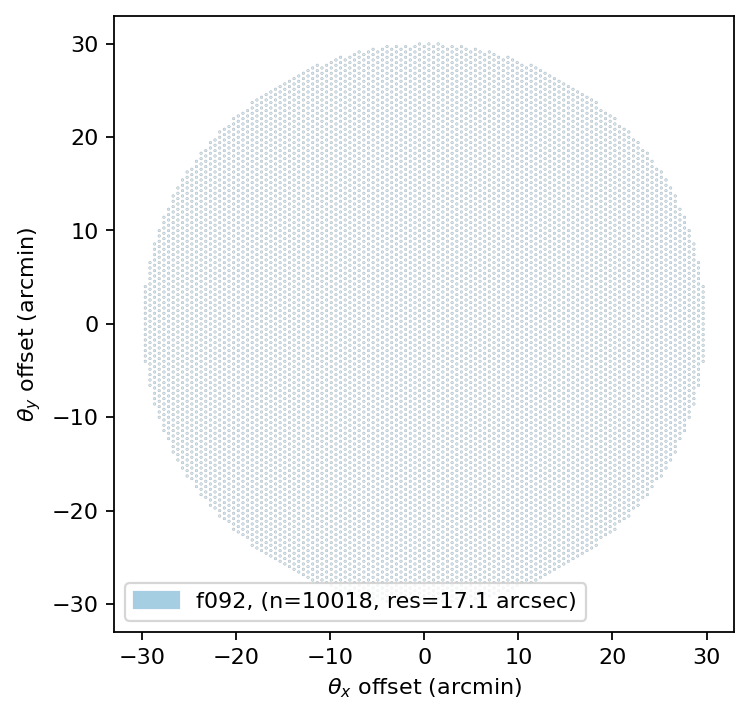

In [3]:
from maria.instrument import Band

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)

array = {"field_of_view": 1.0, "bands": [f090]}
instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)
instrument.plot()

In [4]:
sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                # atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

2024-09-30 18:23:32.089 INFO: Constructed instrument.
2024-09-30 18:23:32.090 INFO: Constructed plan.
2024-09-30 18:23:32.091 INFO: Constructed site.
2024-09-30 18:23:38.761 INFO: Constructed boresight.
2024-09-30 18:23:48.724 INFO: Constructed offsets.


Initialized base in 16636 ms.


Sampling map (f092): 100%|██████████| 1/1 [02:25<00:00, 145.20s/it]


In [5]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

In [6]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(300.0, -10.0),
                   frame="ra_dec",
                   width=1.,
                   height=1.,
                   resolution=np.degrees(np.nanmin(instrument.fwhm))/4.,
                #    tod_postprocessing={
                #         "window": {"tukey": {"alpha": 0.1}},
                #         "remove_modes": {"n": 1},
                #         "highpass": {"f": 0.05},
                #         "despline": {"spacing": 10},
                #     },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 0},
                        # "gaussian_filter": {"sigma": 1},
                        # "median_filter": {"size": 1},
                    },
                  )

# mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

Running mapper (f092): 100%|██████████| 1/1 [03:08<00:00, 188.61s/it]

mapdata_truth shape: (1, 1024, 1024)
mapdata_truth mean: 0.00013284593853240577


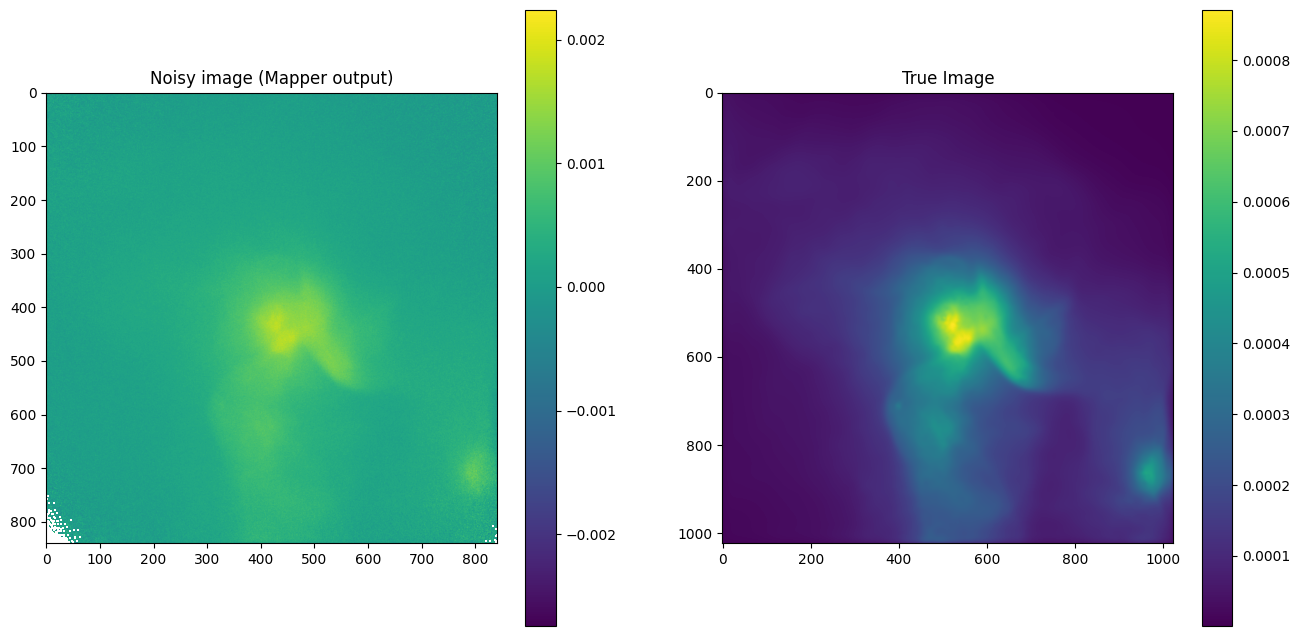

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0])
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-09-30 18:30:31.166 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-09-30 18:30:31.167 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [9]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [10]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [11]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            # (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            (x_side, y_side), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            # jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            filtered_power_map, # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

## Test TOD agreement for noise-free map

(200, 200)


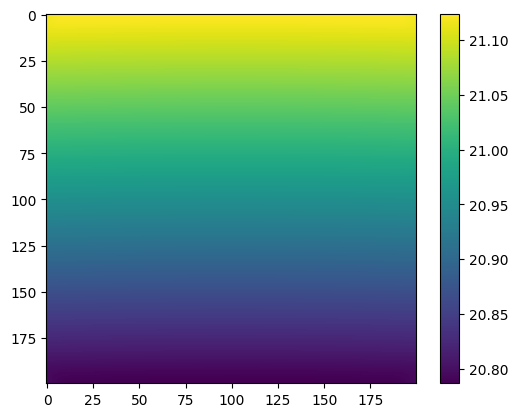

In [12]:
atmosdata_truth = np.float64(np.load('atmosphere.npy')[:, :, 0])

# pad img with average
# atmosdata_truth = np.pad(atmosdata_truth, pad_width=5, mode='constant', constant_values=atmosdata_truth.mean())

print(atmosdata_truth.shape)
plt.imshow(atmosdata_truth)
plt.colorbar()

In [13]:
x_side = np.float64(np.linspace(-0.5, 0.5, 200))
y_side = np.float64(np.linspace(-0.5, 0.5, 200))
# x_side = np.linspace(-0.5*210/200, 0.5*210/200, 210)
# y_side = np.linspace(-0.5*210/200, 0.5*210/200, 210)

In [14]:
print(sim_truthmap.map.resolution)

1.7044230976507124e-05


In [15]:
mapdata_truth.shape

(1, 1024, 1024)

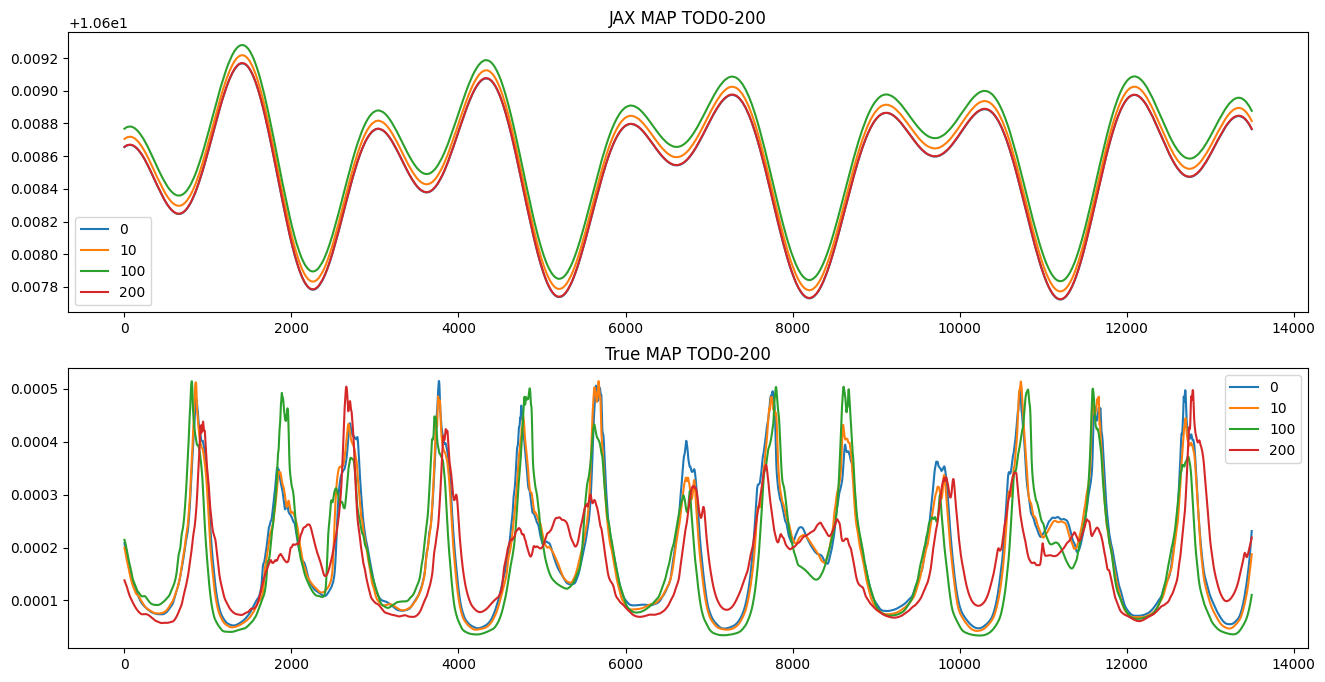

In [16]:
# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
jax_tods = sample_maps(atmosdata_truth[np.newaxis, :, :], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

Noise stddev: 0.0002809496


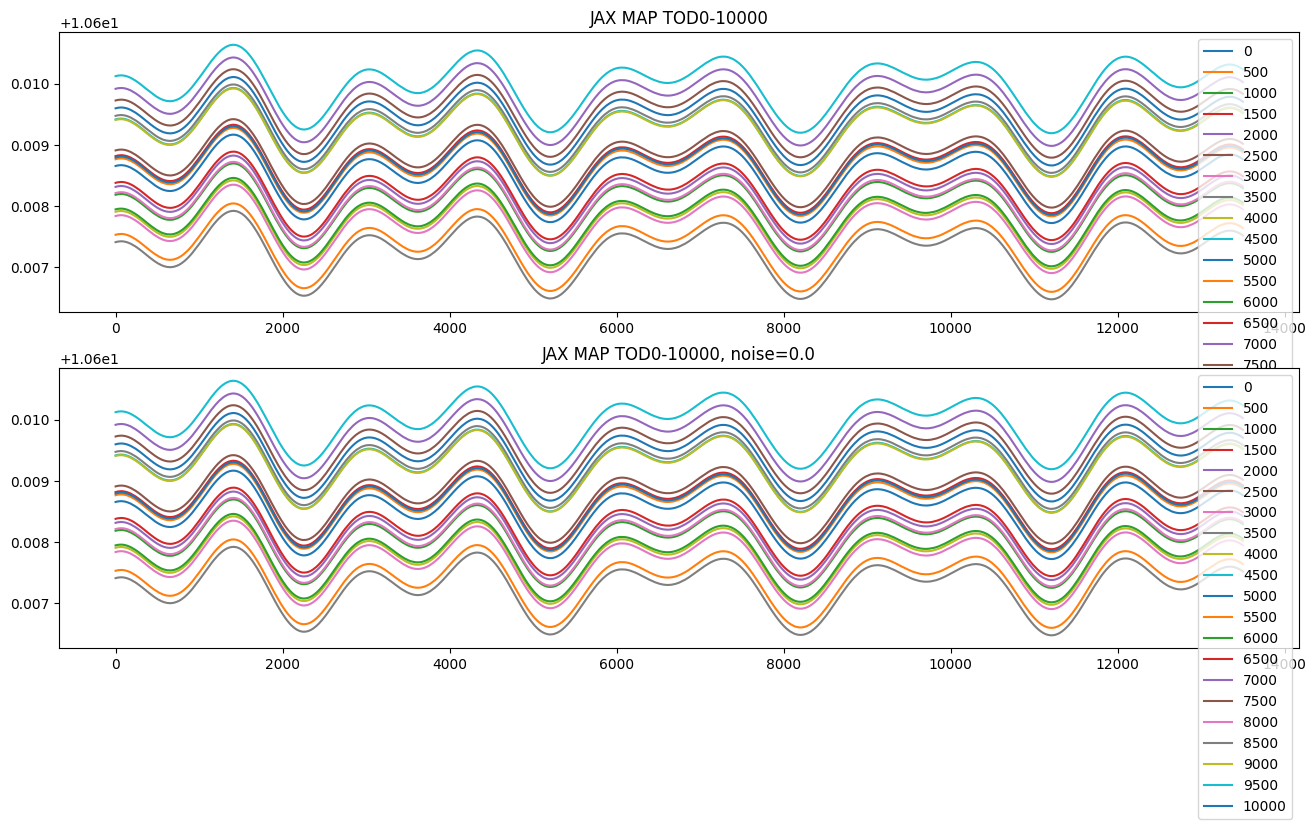

In [17]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
noised_jax_tod = jax_tods + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

In [18]:
# dims = (1000, 1000)
# dims = (1024, 1024)
# dims = (200, 200)
dims = (220, 220)
padding = dims[0] - atmosdata_truth.shape[0]
# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(5e-5, 5e-5))
cf_zm_map = dict(offset_mean=atmosdata_truth.mean(), offset_std=(atmosdata_truth.mean()/3., atmosdata_truth.mean()/3.))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    fluctuations=(1e-2, 2e-3), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-6e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [19]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        # return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1]))[:, padding//2:-padding//2, padding//2:-padding//2], dx, dy, sim_truthmap.map.resolution, x_side, y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
noise_cov_inv_map = lambda x: 1e-4**-2 * x
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_tod = jft.Gaussian( noised_jax_tod, noise_cov_inv_tod).amend(signal_response_tod)
# lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [20]:
key, sub = random.split(key)
# print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(6.00137715e+12, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-7.21004131e+11, dtype=float64),
	 'cfmapxi': Array([[ 2.66517370e+16, -1.28388907e+13,  1.83357775e+12, ...,
	        -5.40201978e+11,  1.73044822e+12, -1.24727488e+13],
	       [-1.28442232e+13,  4.88919717e+12, -1.35566622e+12, ...,
	         4.72701244e+11, -1.28156743e+12,  4.75375368e+12],
	       [ 1.83510018e+12, -1.35623093e+12,  7.06071366e+11, ...,
	        -3.30790430e+11,  6.68566869e+11, -1.31973372e+12],
	       ...,
	       [-5.39512472e+11,  4.71907943e+11, -3.30104311e+11, ...,
	         1.91768098e+11, -3.09867791e+11,  4.57220664e+11],
	       [ 1.72898985e+12, -1.27996364e+12,  6.67459784e+11, ...,
	        -3.10004560e+11,  6.27703066e+11, -1.24127446e+12],
	       [-1.24675304e+13,  4.74980137e+12, -1.31809465e+12, ...,
	         4.57616628e+11, -1.24180443e+12,  4.61035179e+12]],      dtype=float64),
	 'cfmapzeromode': Array(1.27367244e+16, dtype=float64)}
)

# Draw Prior sample

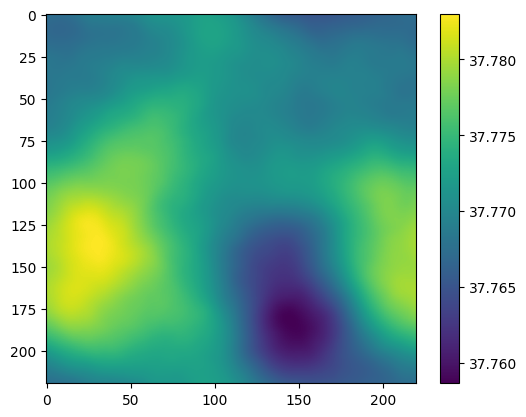

In [21]:
key = random.PRNGKey(123)
key, subkey = jax.random.split(key)
xi = jft.random_like(subkey, gp_map.domain)
res = gp_map(xi)

plt.imshow(res)
plt.colorbar()

In [22]:
todlist_prior = []

for i in range(5):
    key, subkey = jax.random.split(key)
    xi = jft.random_like(subkey, gp_map.domain)
    tod1 = signal_response_tod(xi)
    todlist_prior.append(tod1)
    
    
mean, std = jft.mean_and_std(tuple(todlist_prior))

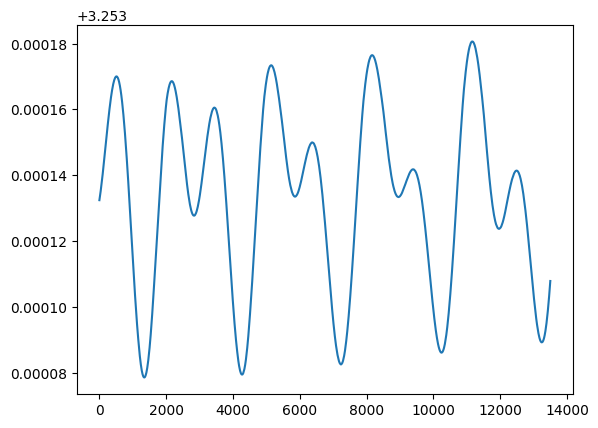

In [23]:
plt.plot(std[0])

# MAP fit

In [24]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:7.508696e+01 ➽:4.840300e+00
M: Iteration 1 ⛰:+2.020223e+13 Δ⛰:1.093493e+15
M: →:1.0 ↺:False #∇²:12 |↘|:2.624833e+01 ➽:4.840300e+00
M: Iteration 2 ⛰:+4.360207e+08 Δ⛰:2.020179e+13
M: →:1.0 ↺:False #∇²:18 |↘|:1.100828e+01 ➽:4.840300e+00
M: Iteration 3 ⛰:+2.572241e+04 Δ⛰:4.359950e+08
M: →:0.5 ↺:False #∇²:24 |↘|:9.605983e+00 ➽:4.840300e+00
M: Iteration 4 ⛰:+2.472113e+04 Δ⛰:1.001276e+03
M: →:0.5 ↺:False #∇²:30 |↘|:1.200299e+01 ➽:4.840300e+00
M: Iteration 5 ⛰:+2.468236e+04 Δ⛰:3.876789e+01
M: →:0.5 ↺:False #∇²:36 |↘|:7.566779e+00 ➽:4.840300e+00
M: Iteration 6 ⛰:+2.453859e+04 Δ⛰:1.437706e+02
M: →:0.5 ↺:False #∇²:42 |↘|:2.101465e+01 ➽:4.840300e+00
M: Iteration 7 ⛰:+2.452580e+04 Δ⛰:1.279274e+01
M: →:1.0 ↺:False #∇²:48 |↘|:9.066080e+00 ➽:4.840300e+00
M: Iteration 8 ⛰:+2.445017e+04 Δ⛰:7.563219e+01
M: →:1.0 ↺:False #∇²:54 |↘|:1.226229e+01 ➽:4.840300e+00
M: Iteration 9 ⛰:+2.439921e+04 Δ⛰:5.096156e+01
M: →:1.0 ↺:False #∇²:60 |↘|:8.871824e+00 ➽:4.8

(200, 200)


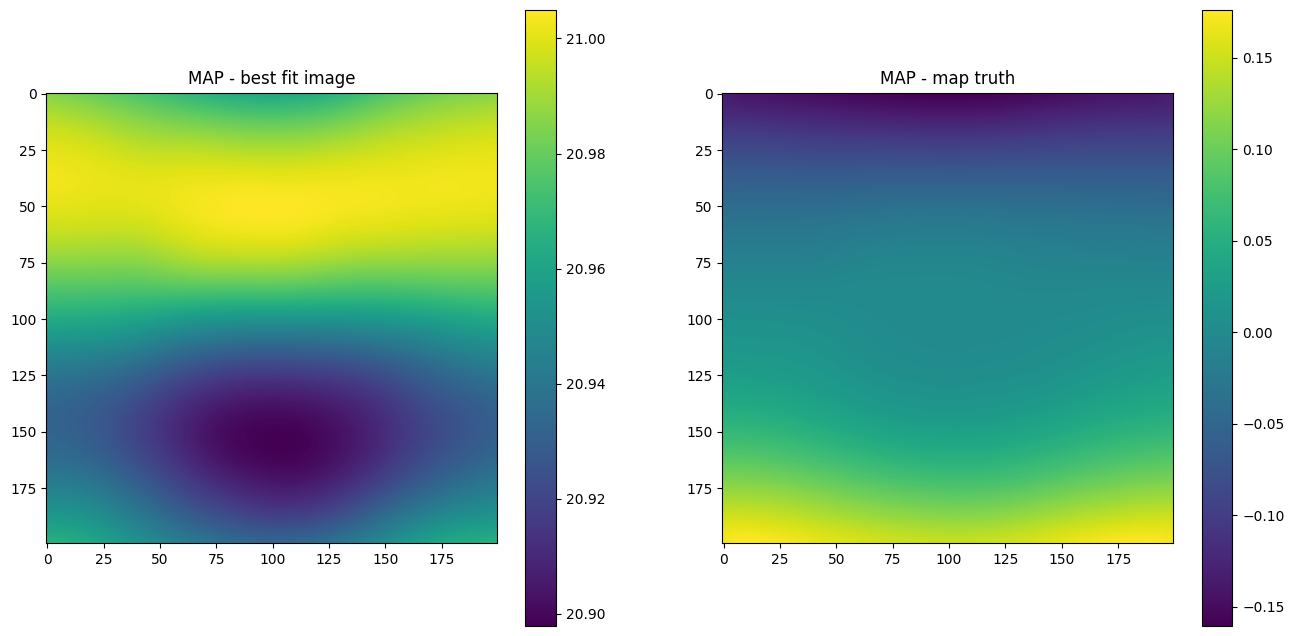

In [25]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos)[padding//2:-padding//2, padding//2:-padding//2] # when splitting up in different field models
print(sig_map.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

# im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
im1 = axes[1].imshow( sig_map - atmosdata_truth )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

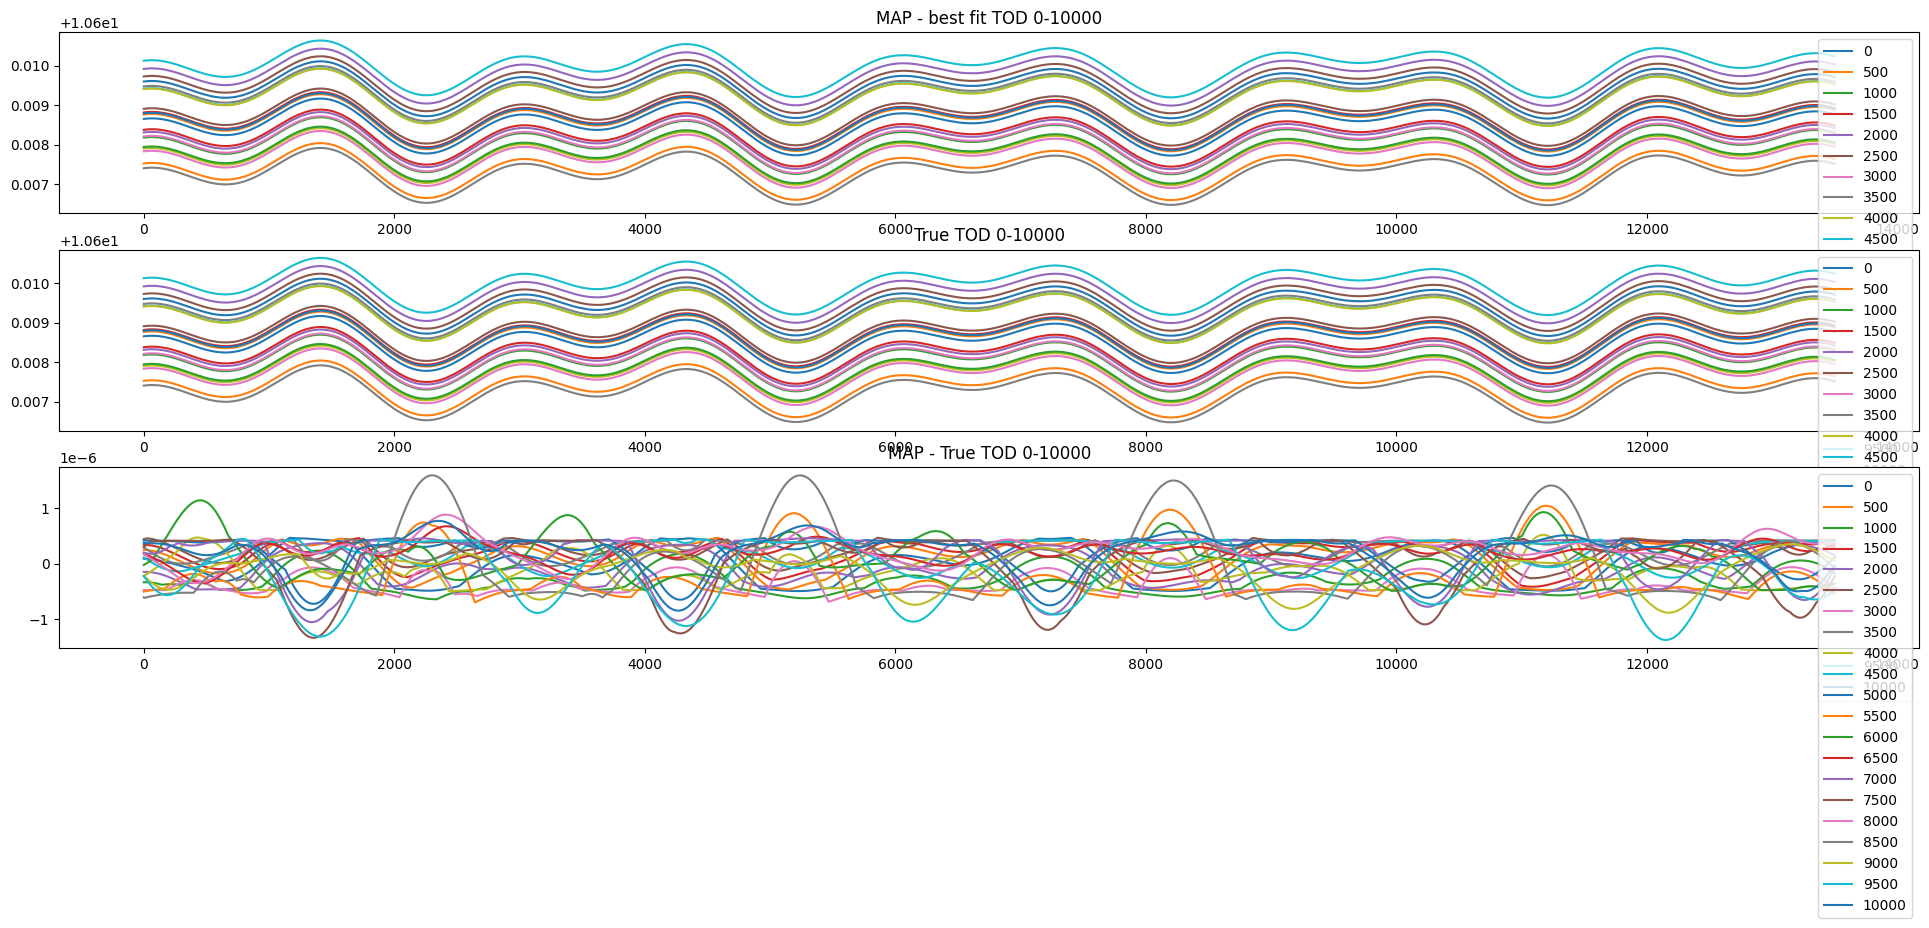

In [26]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(3, 1, figsize=(8*3, 8))

# for i in [0, 10, 100, 200]:
for i in range(0, len(jax_tods), len(jax_tods)//20):
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    im2 = axes[2].plot(pred_tods[i] - jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()
axes[2].title.set_text(f'MAP - True TOD 0-{i}')
axes[2].legend()

plt.show()

In [27]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+5.8601e+14 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+2.6252e+07 Δ⛰:5.8601e+14 ➽:4.8403e-01
SL: Iteration 2 ⛰:+5.6880e+05 Δ⛰:2.5683e+07 ➽:4.8403e-01
SL: Iteration 3 ⛰:+5.6880e+05 Δ⛰:9.8903e-01 ➽:4.8403e-01
SL: Iteration 4 ⛰:+9.2841e+03 Δ⛰:5.5952e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+9.2841e+03 Δ⛰:3.8468e-03 ➽:4.8403e-01
SL: Iteration 6 ⛰:-2.2112e+04 Δ⛰:3.1396e+04 ➽:4.8403e-01
SL: Iteration 7 ⛰:-2.2149e+04 Δ⛰:3.7282e+01 ➽:4.8403e-01
SL: Iteration 8 ⛰:-2.3010e+04 Δ⛰:8.6083e+02 ➽:4.8403e-01
SL: Iteration 9 ⛰:-2.3219e+04 Δ⛰:2.0927e+02 ➽:4.8403e-01
SL: Iteration ✖✖ (10) ⛰:-2.3611e+04 Δ⛰:3.9156e+02 ➽:4.8403e-01
SL: Iteration 0 ⛰:+1.1700e+15 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+9.7913e+06 Δ⛰:1.1700e+15 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.9625e+05 Δ⛰:9.5951e+06 ➽:4.8403e-01
SL: Iteration 3 ⛰:+1.9621e+05 Δ⛰:3.7606e+01 ➽:4.8403e-01
SL: Iteration 4 ⛰:-1.0680e+04 Δ⛰:2.0689e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:-1.0680e+04 Δ⛰:9.4827e-06 ➽:4.8403e-01
SL: Iteratio

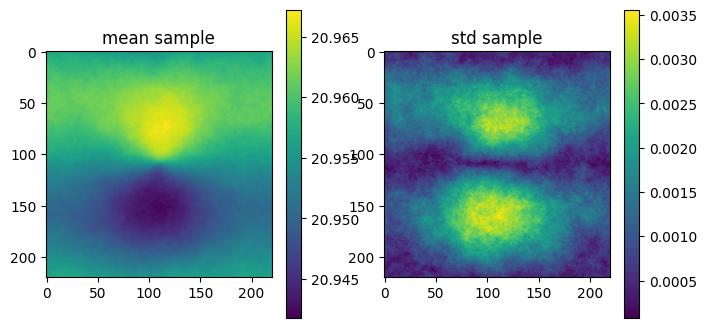

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+3.6569e+06 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+1.9613e+06 Δ⛰:1.6956e+06 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.1059e+06 Δ⛰:8.5543e+05 ➽:4.8403e-01
SL: Iteration 3 ⛰:+3.7054e+05 Δ⛰:7.3536e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.1004e+05 Δ⛰:2.6050e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+6.2834e+04 Δ⛰:4.7209e+04 ➽:4.8403e-01
SL: Iteration 6 ⛰:+4.5334e+03 Δ⛰:5.8301e+04 ➽:4.8403e-01
SL: Iteration 7 ⛰:-1.6592e+03 Δ⛰:6.1926e+03 ➽:4.8403e-01
SL: Iteration 8 ⛰:-1.7840e+03 Δ⛰:1.2481e+02 ➽:4.8403e-01
SL: Iteration 9 ⛰:-2.0088e+04 Δ⛰:1.8304e+04 ➽:4.8403e-01
SL: Iteration ✖✖ (10) ⛰:-2.0116e+04 Δ⛰:2.7266e+01 ➽:4.8403e-01
SL: Iteration 0 ⛰:+5.9032e+07 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+2.1367e+07 Δ⛰:3.7664e+07 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.3335e+06 Δ⛰:2.0034e+07 ➽:4.8403e-01
SL: Iteration 3 ⛰:+8.6923e+05 Δ⛰:4.6426e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.7025e+05 Δ⛰:6.9898e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+1.2673e+05 Δ⛰:4.3517e+04 ➽:4.8403e-01
SL: Iteratio

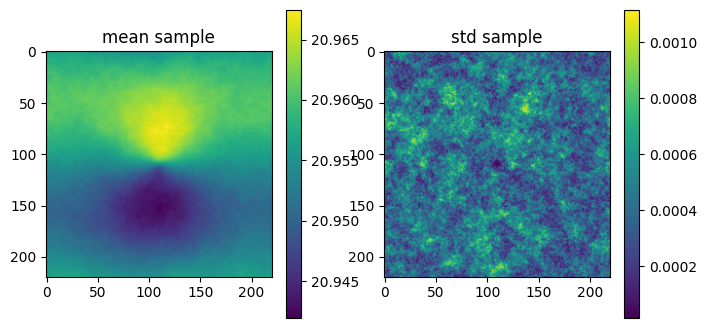

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+5.4185e+07 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+1.7819e+06 Δ⛰:5.2403e+07 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.5505e+06 Δ⛰:2.3135e+05 ➽:4.8403e-01
SL: Iteration 3 ⛰:+5.0586e+05 Δ⛰:1.0447e+06 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.2787e+05 Δ⛰:3.7799e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+4.0804e+04 Δ⛰:8.7069e+04 ➽:4.8403e-01
SL: Iteration 6 ⛰:+1.2438e+04 Δ⛰:2.8366e+04 ➽:4.8403e-01
SL: Iteration 7 ⛰:+6.2285e+03 Δ⛰:6.2093e+03 ➽:4.8403e-01
SL: Iteration 8 ⛰:+1.8823e+03 Δ⛰:4.3462e+03 ➽:4.8403e-01
SL: Iteration 9 ⛰:-4.5144e+03 Δ⛰:6.3966e+03 ➽:4.8403e-01
SL: Iteration ✖✖ (10) ⛰:-6.2345e+03 Δ⛰:1.7201e+03 ➽:4.8403e-01
SL: Iteration 0 ⛰:+7.9486e+06 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+1.7177e+06 Δ⛰:6.2309e+06 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.2388e+06 Δ⛰:4.7887e+05 ➽:4.8403e-01
SL: Iteration 3 ⛰:+6.5269e+05 Δ⛰:5.8613e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+9.0093e+04 Δ⛰:5.6260e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+2.0048e+04 Δ⛰:7.0045e+04 ➽:4.8403e-01
SL: Iteratio

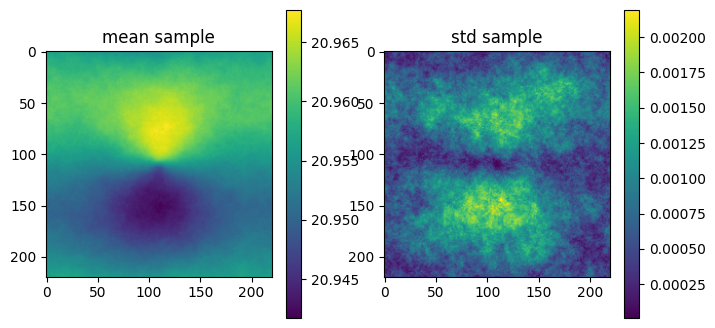

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+2.2170e+07 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+6.8090e+06 Δ⛰:1.5361e+07 ➽:4.8403e-01
SL: Iteration 2 ⛰:+4.4705e+06 Δ⛰:2.3385e+06 ➽:4.8403e-01
SL: Iteration 3 ⛰:+3.8414e+05 Δ⛰:4.0864e+06 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.7023e+05 Δ⛰:2.1391e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+3.4205e+04 Δ⛰:1.3603e+05 ➽:4.8403e-01
SL: Iteration 6 ⛰:-1.1722e+03 Δ⛰:3.5378e+04 ➽:4.8403e-01
SL: Iteration 7 ⛰:-4.9197e+03 Δ⛰:3.7475e+03 ➽:4.8403e-01
SL: Iteration 8 ⛰:-9.0012e+03 Δ⛰:4.0815e+03 ➽:4.8403e-01
SL: Iteration 9 ⛰:-9.1029e+03 Δ⛰:1.0173e+02 ➽:4.8403e-01
SL: Iteration ✖✖ (10) ⛰:-1.2290e+04 Δ⛰:3.1871e+03 ➽:4.8403e-01
SL: Iteration 0 ⛰:+1.4905e+08 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+4.8008e+05 Δ⛰:1.4857e+08 ➽:4.8403e-01
SL: Iteration 2 ⛰:+4.4718e+05 Δ⛰:3.2895e+04 ➽:4.8403e-01
SL: Iteration 3 ⛰:+9.2404e+04 Δ⛰:3.5478e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+3.8616e+04 Δ⛰:5.3788e+04 ➽:4.8403e-01
SL: Iteration 5 ⛰:-4.5251e+03 Δ⛰:4.3141e+04 ➽:4.8403e-01
SL: Iteratio

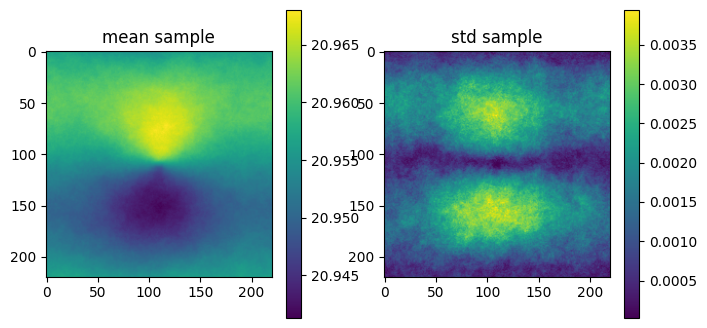

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+1.3982e+07 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+2.7814e+06 Δ⛰:1.1201e+07 ➽:4.8403e-01
SL: Iteration 2 ⛰:+1.3272e+06 Δ⛰:1.4542e+06 ➽:4.8403e-01
SL: Iteration 3 ⛰:+7.5428e+05 Δ⛰:5.7295e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.4047e+05 Δ⛰:6.1381e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+3.1123e+04 Δ⛰:1.0935e+05 ➽:4.8403e-01
SL: Iteration 6 ⛰:-7.3008e+03 Δ⛰:3.8424e+04 ➽:4.8403e-01
SL: Iteration 7 ⛰:-7.4306e+03 Δ⛰:1.2976e+02 ➽:4.8403e-01
SL: Iteration 8 ⛰:-1.0482e+04 Δ⛰:3.0515e+03 ➽:4.8403e-01
SL: Iteration 9 ⛰:-1.0493e+04 Δ⛰:1.0775e+01 ➽:4.8403e-01
SL: Iteration ✖✖ (10) ⛰:-1.3098e+04 Δ⛰:2.6047e+03 ➽:4.8403e-01
SL: Iteration 0 ⛰:+3.0440e+07 Δ⛰:inf ➽:4.8403e-01
SL: Iteration 1 ⛰:+3.8799e+06 Δ⛰:2.6560e+07 ➽:4.8403e-01
SL: Iteration 2 ⛰:+8.5255e+05 Δ⛰:3.0274e+06 ➽:4.8403e-01
SL: Iteration 3 ⛰:+5.5860e+05 Δ⛰:2.9395e+05 ➽:4.8403e-01
SL: Iteration 4 ⛰:+1.7497e+05 Δ⛰:3.8363e+05 ➽:4.8403e-01
SL: Iteration 5 ⛰:+9.9329e+04 Δ⛰:7.5641e+04 ➽:4.8403e-01
SL: Iteratio

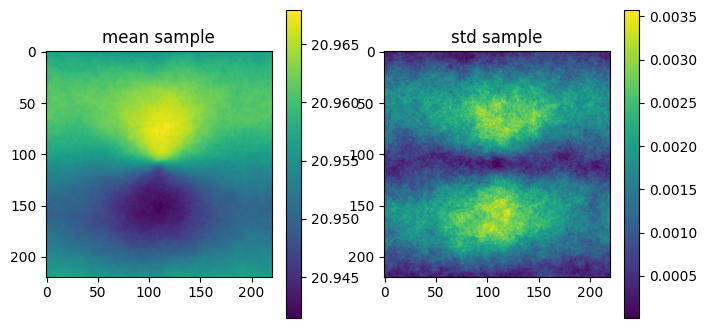

In [28]:
# n_it = 1
n_it = 5
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

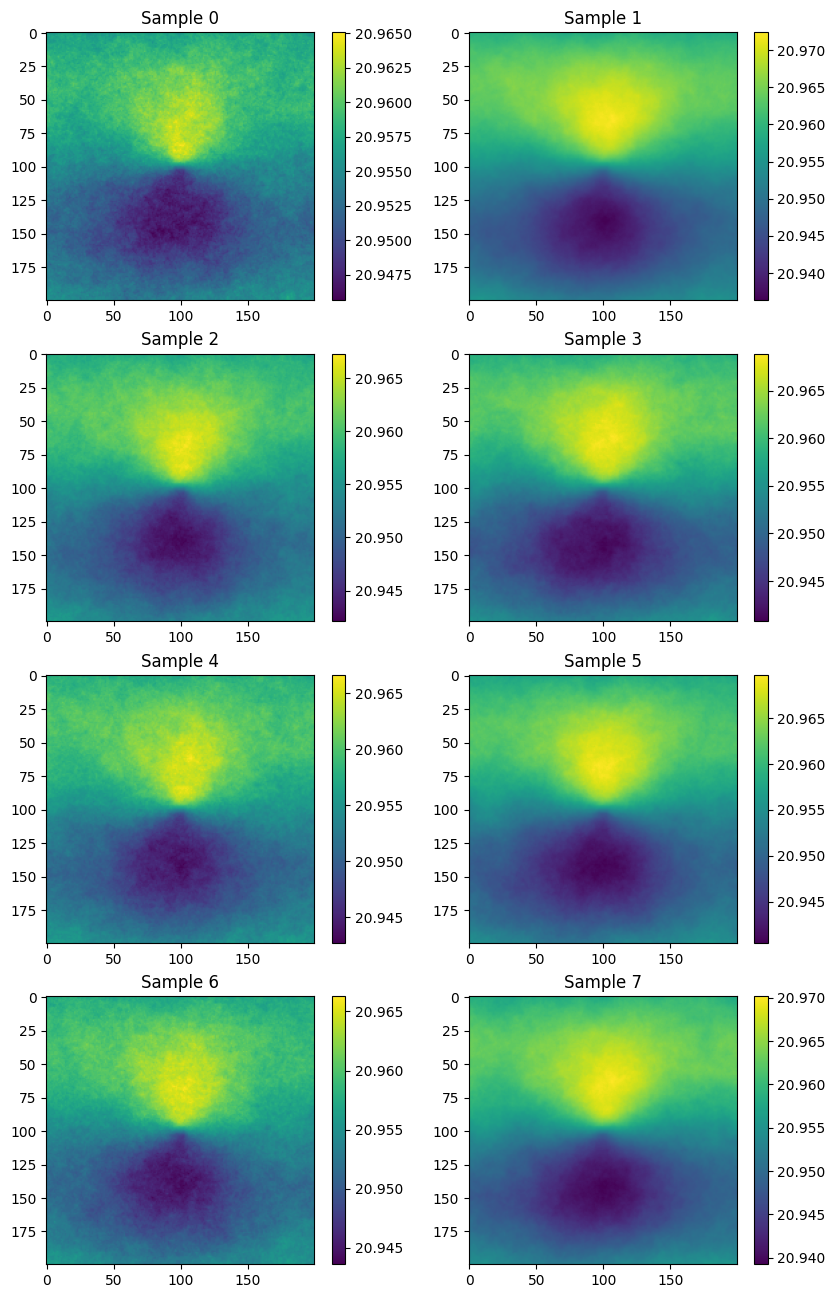

In [29]:
# plot all samples
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//2][i%2].imshow(gp_map(s)[padding//2:-padding//2, padding//2:-padding//2])
    axes[i//2][i%2].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

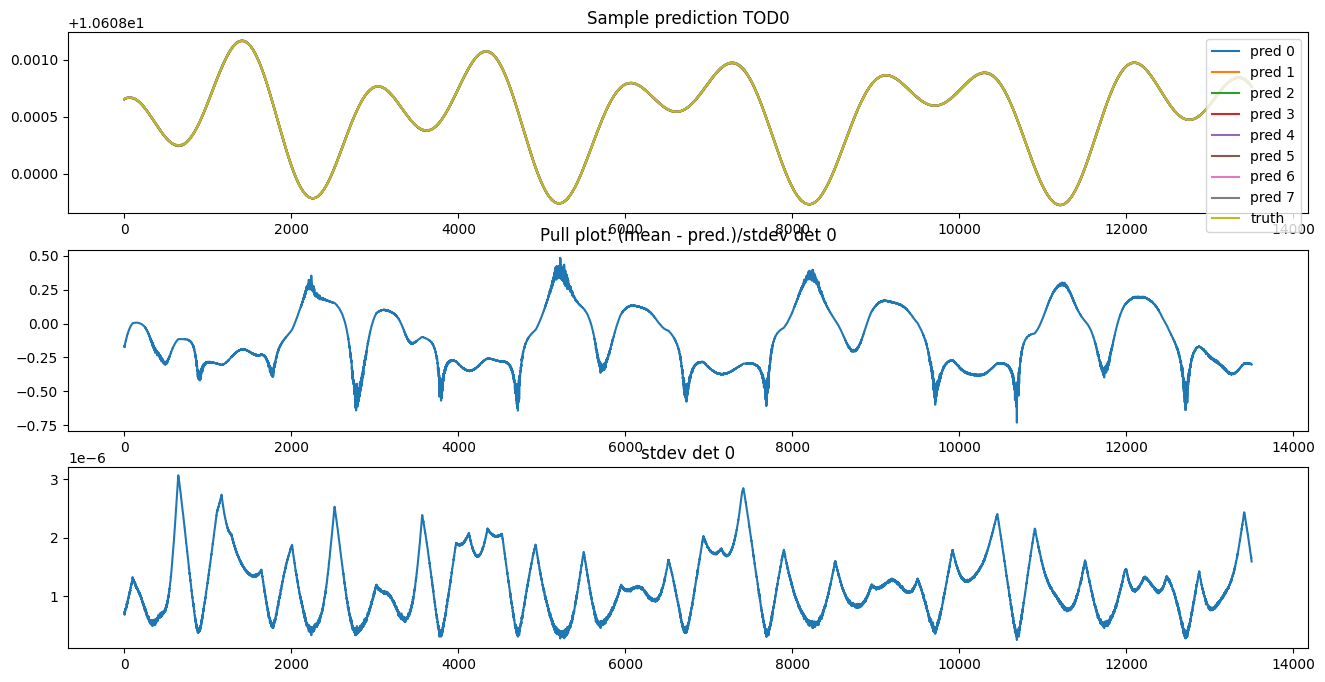

In [30]:
# plot time-series for det 0 for all samples:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))

mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

i = 0
for s in samples:

    axes[0].plot(signal_response_tod(s)[0], label=f"pred {i}")
    # axes[1].plot((signal_response_tod(s)[0] - jax_tods[0])/std[0], label=i)
    i += 1

axes[0].plot(jax_tods[0], label="truth")
axes[0].set_title("Sample prediction TOD0")
axes[0].legend()

# axes[1].plot(jax_tods[0])
axes[1].plot((mean[0] - jax_tods[0])/std[0])
axes[1].set_title(f"Pull plot: (mean - pred.)/stdev det 0")

axes[2].plot(std[0])
axes[2].set_title(f"stdev det 0")

plt.show()

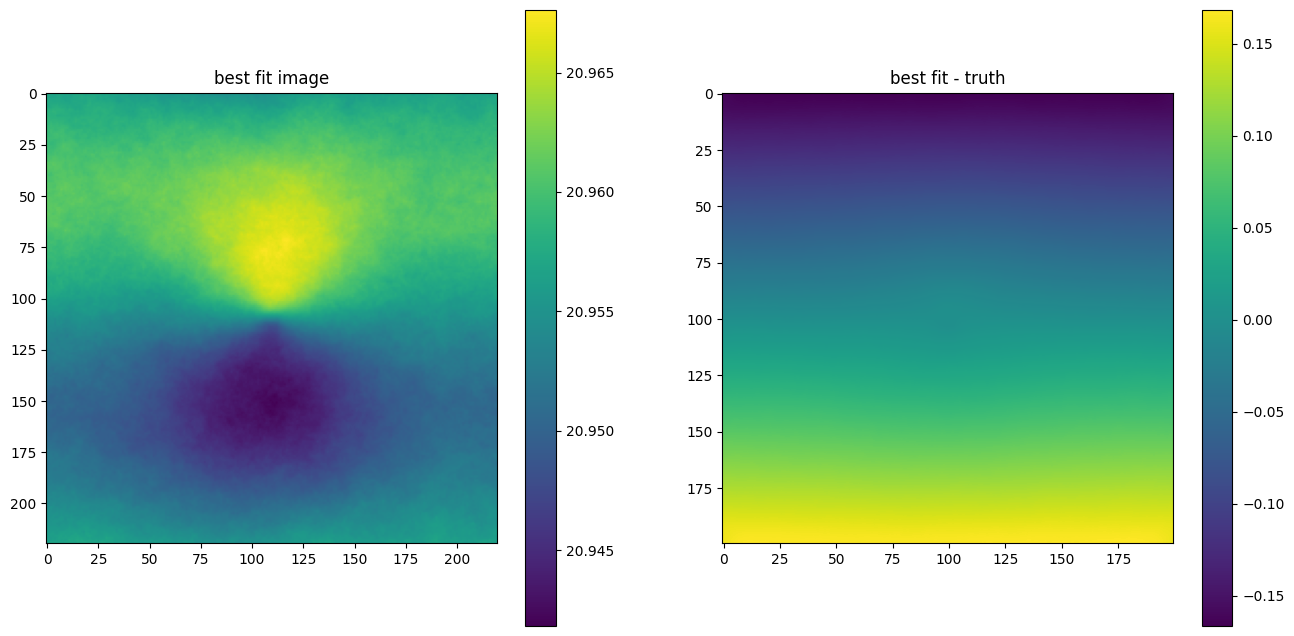

In [31]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map[padding//2:-padding//2, padding//2:-padding//2] - atmosdata_truth)
axes[1].title.set_text('best fit - truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()